# EEG Machine Learning Pipeline

## TO DO - To Review

Projects:
- Pickle: https://www.perplexity.ai/search/in-a-jupyter-notebook-i-have-c-0LbAAH9ITFGfcPYaWlrt6Q

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

# Imports & Utilities

In [29]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Random Forest
from sklearn.ensemble import RandomForestClassifier




In [2]:
# A utility function to establish relative paths for a given folder
def get_folder_path(folder_name):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
     
    return folder_path

# Utility function to check for the existence of a file in a given directory
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path

def get_file_path_project(relative_folder, file_name):
    project_root = os.path.dirname(os.getcwd())
    file_path = os.path.join(project_root, relative_folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path

In [3]:
# Read dataframe usng pickle        
def load_dataframe(file_path):

    try:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f'File not found: {file_path}')
        
        df = pd.read_pickle(file_path)
        print(f"DataFrame loaded: shape {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading DataFrame: {e}")
        return None

# Data Load

In [4]:
# Load the EEG Study data
# study_params_df - summary of the parameters used in the EEG processing
# study_subjects_df - list of all subjects in the study
# study_features_raw_df - full features set resulting fron the EEG pipeline, raw and not cleaned for ML use



In [5]:
# Data Folders
EEG_results_folder = 'Data/EEG_Datasets_Processed'
EEG_studies_folder = 'Data/EEG_Studies'

# Study Name
study_name = 'ds004584-1.0.0_20250615'

# Load the dataframes
df_file_path = get_file_path_project(EEG_results_folder + '/' + study_name,'study_details_df.pkl') 
study_params_df = load_dataframe(df_file_path)
# study_subjects_df = study_params_df['subjects_df']
# TODO: Load the subjects_df having changed the EEG Pipeline to save the subjects_df seperately
# TODO: At the same time reorganise the data folders into studies?

df_file_path = get_file_path_project(EEG_results_folder + '/' + study_name,'study_features_df.pkl') 
study_features_raw_df = load_dataframe(df_file_path)



DataFrame loaded: shape (1, 6)
DataFrame loaded: shape (149, 2248)


# Features Inspection, Cleaning & Reduction

In [6]:
study_features_cleaned_df = study_features_raw_df.copy()

# Drop features
dropped_variables = ['subject_id']
study_features_cleaned_df.drop(dropped_variables, axis=1, inplace=True)

# Before and After
print(study_features_raw_df.shape)
print(study_features_cleaned_df.shape)

(149, 2248)
(149, 2247)


# Data Split ...

In [7]:
# Separate features (X) and target variable (y)
targetName = "pd"
featureNames = study_features_cleaned_df.columns[study_features_cleaned_df.columns != targetName]

X = study_features_cleaned_df[featureNames]
y = study_features_cleaned_df[targetName]

# Split of training and testing data, 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

del targetName, featureNames, X, y

# Transforms  ....

In [8]:
# Establish a transformation for categorical and numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns

print(f'Numerics {len(numerical_features)} \n', numerical_features)
print(f'Categoricals {len(categorical_features)} \n', categorical_features)

transformations = [
    ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_features),
    ('num', RobustScaler(), numerical_features)
]

# Add to pipeline, and later add other actions such as dropping rows, imputing etc etc
data_prep_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('col_transform', ColumnTransformer(transformers=transformations))
])
data_prep_pipeline.fit(X_train)

Numerics 2245 
 Index(['age', 'chn_0_offset', 'chn_0_exponent', 'chn_0_cf_0', 'chn_0_pw_0',
       'chn_0_bw_0', 'chn_0_cf_1', 'chn_0_pw_1', 'chn_0_bw_1', 'chn_0_cf_2',
       ...
       'chn_65_pw_7', 'chn_65_bw_7', 'chn_65_cf_8', 'chn_65_pw_8',
       'chn_65_bw_8', 'chn_65_cf_9', 'chn_65_pw_9', 'chn_65_bw_9',
       'chn_65_error', 'chn_65_r_squared'],
      dtype='object', length=2245)
Categoricals 1 
 Index(['gender'], dtype='object')


,steps,"[('col_transform', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
# Transform the separate datasets
X_train_transformed = data_prep_pipeline.transform(X_train)
X_test_transformed = data_prep_pipeline.transform(X_test)

In [10]:
display(f'Original: {study_features_raw_df.shape}')
display(f'Cleaned: {study_features_cleaned_df.shape}')

display(f'X_Train: {X_train_transformed.shape}')
display(f'X_Test: {X_test_transformed.shape}')
display(data_prep_pipeline.get_feature_names_out())
feature_names = data_prep_pipeline.get_feature_names_out()

'Original: (149, 2248)'

'Cleaned: (149, 2247)'

'X_Train: (119, 2246)'

'X_Test: (30, 2246)'

array(['cat__gender_M', 'num__age', 'num__chn_0_offset', ...,
       'num__chn_65_bw_9', 'num__chn_65_error', 'num__chn_65_r_squared'],
      dtype=object)

# Working ......

In [19]:
# Create custom scorers to cater for 'yes/no' vs '0/1' target variable 
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
custom_precision_score = make_scorer(precision_score, pos_label='yes')
custom_recall_score = make_scorer(recall_score, pos_label='yes')
custom_f1_score = make_scorer(f1_score, pos_label='yes')

# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [34]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label=1)
    plt.show()

    plt.style.use('ggplot')

In [31]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_transformed, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy: 0.7333
Precision: 0.7200
Recall: 0.9474
F1 Score 0.8182
Specificity: 0.3636
Hamming Loss 0.2667
ROC-AUC Score 0.8230
Gini Index: 0.6459


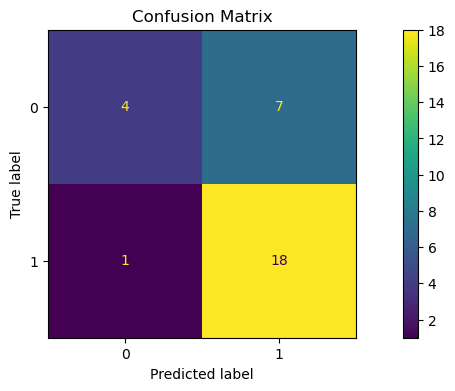

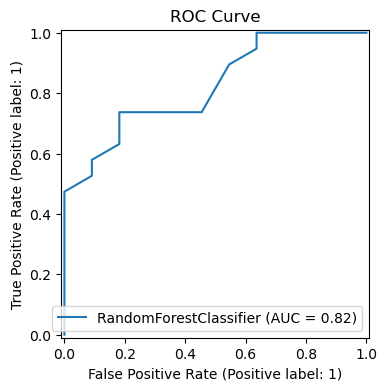

In [35]:
# Show the results


# Get the Best Model & Calculate Predicted Y and Evaluate
y_pred = model.predict(X_test_transformed)
classification_metrics(model, X_test_transformed, y_test, y_pred)

In [22]:
# Decision Tree

# Establish a pipeline for a grid search & get the best fitted model
randforest_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42)
)
grid_params = {
    # 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']      # Default gini. Tree split evaluation function
    'randomforestclassifier__criterion': ['entropy'],                           # Default gini. Tree split evaluation function, 
    # 'randomforestclassifier__n_estimators': [100, 200]                        # Default 100. Number of trees
    'randomforestclassifier__max_depth': [50],                                  # Default none
    # 'randomforestclassifier__max_leaf_nodes': [5, 50],
    # 'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__class_weight': ['balanced']            # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
}                       

# Run the search
start_time = time.perf_counter()
randforest_search = GridSearchCV(randforest_pipeline, grid_params, scoring=custom_precision_score, cv=5)
# randforest_search = RandomizedSearchCV(randforest_pipeline, grid_params, cv=5)
randforest_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^

In [ ]:
# Show the results
print_search_results(randforest_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = randforest_search.best_estimator_
y_pred = model_randforest.predict(X_test)
classification_metrics(model_randforest, X_test, y_test, y_pred)